Justyna Mazurkiewicz-Nedza
06.06.2024

# Example Dashboard

## Packed bubble chart

The presented algorithm tries to move all bubbles as close to the center of mass as possible while avoiding some collisions by moving around colliding objects. In this example we plot the market share of different desktop browsers.


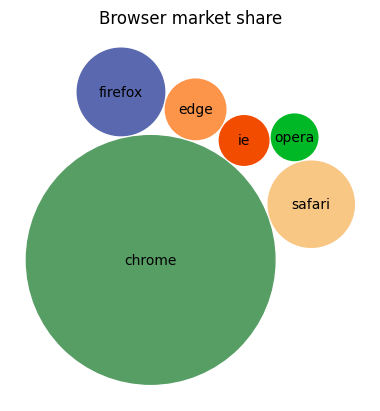

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the bubble chart
browser_market_share = {
    'browsers': ['firefox', 'chrome', 'safari', 'edge', 'ie', 'opera'],
    'market_share': [8.61, 69.55, 8.36, 4.12, 2.76, 2.43],
    'color': ['#5A69AF', '#579E65', '#F9C784', '#FC944A', '#F24C00', '#00B825']
}

class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3])

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0], bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return np.argmin(distance, keepdims=True)

    def collapse(self, n_iterations=50):
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                dir_vec = self.com - self.bubbles[i, :2]
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        new_point1 = (self.bubbles[i, :2] + orth * self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth * self.step_dist)
                        dist1 = self.center_distance(self.com, np.array([new_point1]))
                        dist2 = self.center_distance(self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels, colors):
        for i in range(len(self.bubbles)):
            circ = plt.Circle(self.bubbles[i, :2], self.bubbles[i, 2], color=colors[i])
            ax.add_patch(circ)
            ax.text(*self.bubbles[i, :2], labels[i],
                    horizontalalignment='center', verticalalignment='center')

bubble_chart = BubbleChart(area=browser_market_share['market_share'], bubble_spacing=0.1)
bubble_chart.collapse()

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
bubble_chart.plot(ax, browser_market_share['browsers'], browser_market_share['color'])
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title('Browser market share')

plt.show()


## Multicoloured lines

This example shows how to make a multicolored line. In this example, the line is colored based on its derivative

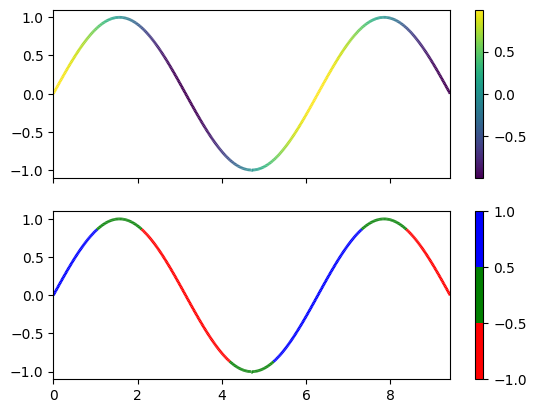

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm, ListedColormap

x = np.linspace(0, 3 * np.pi, 500)
y = np.sin(x)
dydx = np.cos(0.5 * (x[:-1] + x[1:]))  # first derivative

# Create a set of line segments so that we can color them individually
# This creates the points as an N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap='viridis', norm=norm)
# Set the values used for colormapping
lc.set_array(dydx)
lc.set_linewidth(2)
line = axs[0].add_collection(lc)
fig.colorbar(line, ax=axs[0])

# Use a boundary norm instead
cmap = ListedColormap(['r', 'g', 'b'])
norm = BoundaryNorm([-1, -0.5, 0.5, 1], cmap.N)
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(dydx)
lc.set_linewidth(2)
line = axs[1].add_collection(lc)
fig.colorbar(line, ax=axs[1])

axs[0].set_xlim(x.min(), x.max())
axs[0].set_ylim(-1.1, 1.1)
plt.show()

## Bar of Pie

Make a "bar of pie" chart where the first slice of the pie is "exploded" into a bar chart with a further breakdown of said slice's characteristics. The example demonstrates using a figure with multiple sets of Axes and using the Axes patches list to add two ConnectionPatches to link the subplot charts.

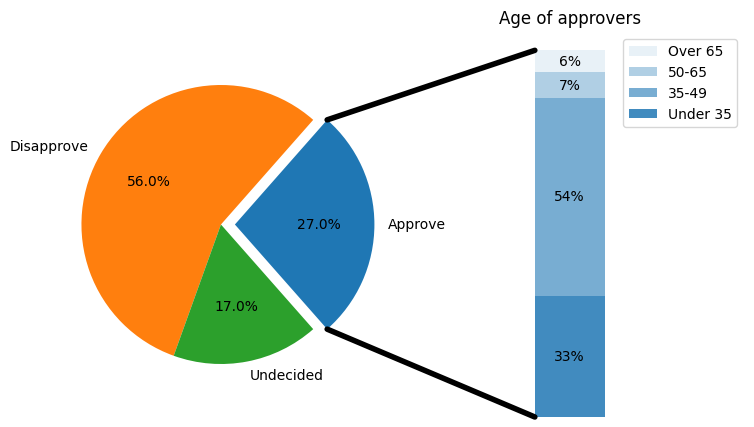

In [5]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import ConnectionPatch

# make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
fig.subplots_adjust(wspace=0)

# pie chart parameters
overall_ratios = [.27, .56, .17]
labels = ['Approve', 'Disapprove', 'Undecided']
explode = [0.1, 0, 0]
# rotate so that first wedge is split by the x-axis
angle = -180 * overall_ratios[0]
wedges, *_ = ax1.pie(overall_ratios, autopct='%1.1f%%', startangle=angle,
                     labels=labels, explode=explode)

# bar chart parameters
age_ratios = [.33, .54, .07, .06]
age_labels = ['Under 35', '35-49', '50-65', 'Over 65']
bottom = 1
width = .2

# Adding from the top matches the legend.
for j, (height, label) in enumerate(reversed([*zip(age_ratios, age_labels)])):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, color='C0', label=label,
                 alpha=0.1 + 0.25 * j)
    ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')

ax2.set_title('Age of approvers')
ax2.legend()
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[0].theta1, wedges[0].theta2
center, r = wedges[0].center, wedges[0].r
bar_height = sum(age_ratios)

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(4)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(4)

plt.show()